# GCs formation and evolution

Import needed packages for running the notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import interpn
import pynbody

Load simulation snapshot

In [2]:
datadir = '/home/pdcg/Documents/post_process_routines/'
simulation = 'rlx_fixed/'
s = pynbody.load(datadir+simulation+'snapdir_127/snapshot_127')

/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/snapshot/gadgethdf.py:370: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


### Perform initial data analysis and units conversion
First center and rotate main galaxy

In [3]:
s.properties['Redshift']

2.220446049250313e-16

In [4]:
s['eps'] = s['smooth']

In [5]:
h = s.halos()

In [6]:
transform = pynbody.analysis.angmom.faceon(h[1])

Change units to physical units (position and mass mainly)

In [7]:
s.physical_units()

Define masks to retrieve stars with clusters, cluster masses, and mass losses

In [8]:
mask_clusters_initial = h[1].s['InitialNumberOfClusters'] > 0
mask_clusters_final = h[1].s['NumberOfClusters'] > 0

truncation_mass = h[1].s['ICMFTruncationMass'][mask_clusters_initial]
cluster_masses = h[1].s['ClusterMass'][mask_clusters_initial].flatten()
init_cluster_masses = h[1].s['InitialClusterMass'][mask_clusters_initial].flatten()
masslostrelax = h[1].s['MassLostRelaxation'][mask_clusters_initial].flatten()
masslostshock = h[1].s['MassLostShocks'][mask_clusters_initial].flatten()

not_empty_clusters = (init_cluster_masses>0)

cluster_masses = cluster_masses[not_empty_clusters]
init_cluster_masses = init_cluster_masses[not_empty_clusters]
masslostrelax = masslostrelax[not_empty_clusters]
masslostshock = masslostshock[not_empty_clusters]

print('Maximum initial mass {:2.2e} Msun'.format(init_cluster_masses.max()))
print('Maximum present-day mass {:2.2e} Msun'.format(cluster_masses.max()))

Maximum initial mass 6.75e+07 Msun
Maximum present-day mass 3.72e+07 Msun


SimArray([[1653139.4, 1681438.8, 1709738.5, ..., 1534445.2, 1535031.5,
           1535617.9],
          [1790451.4, 1822243.5, 1854035.6, ..., 1553374.5, 1554914.4,
           1556454.4],
          [1927763.9, 1963048.4, 1998332.9, ..., 1572303.8, 1574797.2,
           1577290.6],
          ...,
          [3388720.2, 3457774.5, 3526828.8, ..., 7738602. , 7480630.5,
           7222660. ],
          [3335260.2, 3407513. , 3479766. , ..., 7645193.5, 7387921. ,
           7130648.5],
          [3281800.5, 3357251.5, 3432702.8, ..., 7551786.5, 7295212. ,
           7038636.5]], dtype=float32, 'Msol kpc**-2')

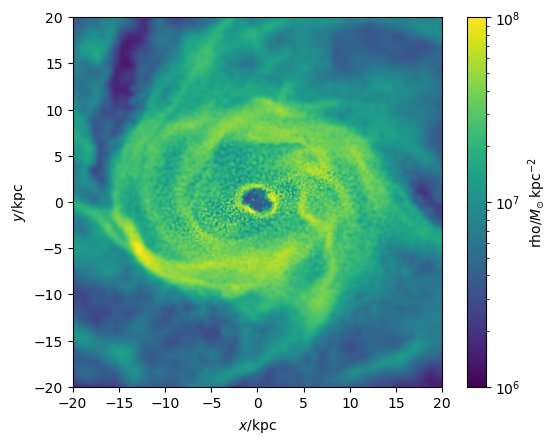

In [46]:
pynbody.plot.sph.image(h[0].g, qty='rho', units='Msol kpc^-2', width=40, cmap=cm.viridis, log=True, vmin=1e6, vmax=1e8)

SimArray([[0.00027207, 0.00027207, 0.00027207, ..., 0.00027207,
           0.00027207, 0.00027207],
          [0.00027207, 0.00027207, 0.00027207, ..., 0.00027207,
           0.00027207, 0.00027207],
          [0.00027207, 0.00027207, 0.00027207, ..., 0.00027207,
           0.00027207, 0.00027207],
          ...,
          [0.00027207, 0.00027207, 0.00027207, ..., 0.00027207,
           0.00027207, 0.00027207],
          [0.00027207, 0.00027207, 0.00027207, ..., 0.00027207,
           0.00027207, 0.00027207],
          [0.00027207, 0.00027207, 0.00027207, ..., 0.00027207,
           0.00027207, 0.00027207]], dtype=float32, 'Msol kpc**-2')

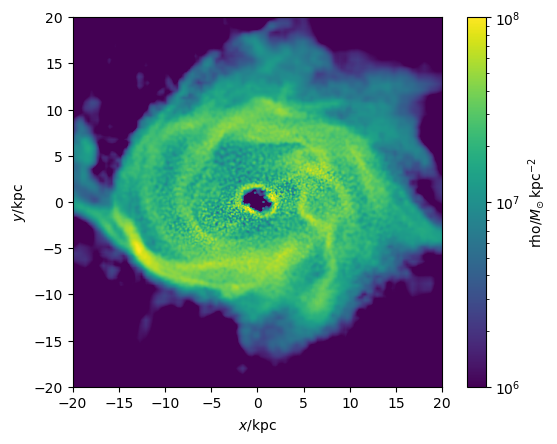

In [47]:
pynbody.plot.sph.image(h[1].g, qty='rho', units='Msol kpc^-2', width=40, cmap=cm.viridis, log=True, vmin=1e6, vmax=1e8)

Now, let's retrieve the birthtime, disruption time and age of the clusters. The time of birth of clusters is the one of its parent particle. Therefore, it is needed to expand this array for each cluster of every star with clusters. Additionally, surviving clusters are given a disruption time in the future.

In [28]:
clusters_birthtime = []
clusters_age = []
for i, nclt in enumerate(h[1].s['InitialNumberOfClusters'][mask_clusters_initial]):
  clusters_birthtime.append(np.ones(nclt) * h[1].s['tform'].in_units('Gyr')[mask_clusters_initial][i])
  clusters_age.append(np.ones(nclt) * h[1].s['age'].in_units('Gyr')[mask_clusters_initial][i])

clusters_birthtime = np.concatenate(clusters_birthtime)
clusters_age = np.concatenate(clusters_age)

In [21]:
clusters_disruptiontime = h[1].s['DisruptionTime'][mask_clusters_initial].flatten()
clusters_disruptiontime = clusters_disruptiontime[not_empty_clusters]
disruption_gyr = np.nan_to_num(pynbody.analysis.cosmology.age(s,z = 1./clusters_disruptiontime - 1.), nan=0.)

/tmp/ipykernel_91982/538201836.py:3: RuntimeWarning: divide by zero encountered in divide
  disruption_gyr = np.nan_to_num(pynbody.analysis.cosmology.age(s,z = 1./clusters_disruptiontime - 1.), nan=0.)
/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/analysis/cosmology.py:182: RuntimeWarning: divide by zero encountered in log
  log_a_input = np.log(1./(1.+z))


And finally define the lifetime and age in gigayears

In [44]:
lifetime_gyr = disruption_gyr - clusters_birthtime
lifetime_gyr[np.logical_not(disruption_gyr>0)] = 16

Just for curiosity, check how many stars formed more mass in clusters than its actual mass

In [29]:
mask_problematic = h[1].s['InitialMassFractionInClusters']>1
print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
print('That`s {:.3f}% of stars with clusters'.format(mask_problematic.sum()/mask_clusters_initial.sum() * 100))

Problematic stars with clusters  206
That`s 0.839% of stars with clusters


Ratio of surviving clusters

In [30]:
# Ratio of stars containing clusters
print(mask_clusters_final.sum()/mask_clusters_initial.sum())
# Ration of actual number of clusters
print((h[1].s['NumberOfClusters']*mask_clusters_final).sum()/(h[1].s['InitialNumberOfClusters']*mask_clusters_initial).sum())

0.598184113024714
0.5572373041435594


It could be interesting to check how that changes with increasing the resolution of the simulation.

## Initial vs present day mass function

Now, all is set up to compare the ICMF to the present day GCMF. First, define the bounds and domain of each MF:

In [31]:
min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.logspace(np.log10(min_icmf), np.log10(max_icmf), 25)

min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), 25)

Load observations data:
- Milky Way's GCMF
- M31's (Andromeda) GCMF

In [32]:
MW_gcmf = np.loadtxt('MW_GCMF.csv', delimiter=',')
M31_gcmf = np.loadtxt('M31_GCMF.csv', delimiter=',')

Load other simulations data:
- EMP Pathfinder fiducial model ($\tau > 10$ Gyr)
- EMP Pathfinder Schechter model ($\tau > 10$ Gyr)
- E-MOSAICS ($\tau > 10$ Gyr)

In [33]:
empfiducial_gcmf = np.loadtxt('Fiducial_emppathfinder.csv', delimiter=',')
empschecter_gcmf = np.loadtxt('Schechter_emppathfinder.csv', delimiter=',')
emosaics_gcmf = np.loadtxt('emosaics.csv', delimiter=',')

/tmp/ipykernel_91982/2494523906.py:3: RuntimeWarning: divide by zero encountered in log10
  N, _ = np.histogram(np.log10(cluster_masses), bins=np.log10(marray_gcmf))#, histtype='step', label='ICMF')


Text(0, 0.5, 'Mass Distribution')

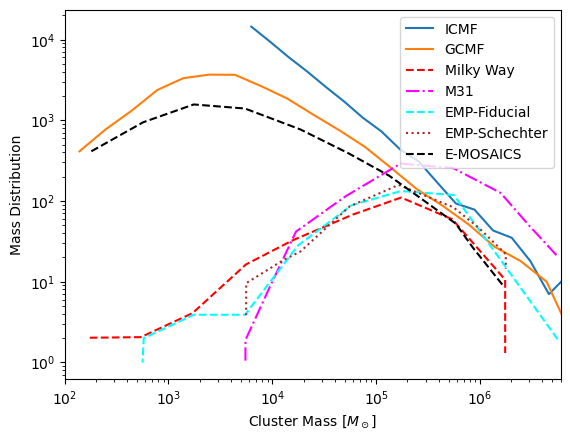

In [34]:
N, _ = np.histogram(np.log10(init_cluster_masses), bins=np.log10(marray_icmf))#, histtype='step', label='ICMF')
plt.plot((marray_icmf[:-1] + marray_icmf[1:])/2, N, label='ICMF')
N, _ = np.histogram(np.log10(cluster_masses), bins=np.log10(marray_gcmf))#, histtype='step', label='ICMF')
plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2, N, label='GCMF')
# plt.hist(init_cluster_masses, bins=marray_icmf, histtype='step', label='ICMF')
# plt.hist(cluster_masses, bins=marray_gcmf, histtype='step', label='GCMF')
plt.plot(MW_gcmf[:,0], MW_gcmf[:,1], linestyle='dashed', color='red', label='Milky Way')
plt.plot(M31_gcmf[:,0], M31_gcmf[:,1], linestyle='dashdot', color='magenta', label='M31')
plt.plot(empfiducial_gcmf[:,0], empfiducial_gcmf[:,1], linestyle='dashed', color='cyan', label='EMP-Fiducial')
plt.plot(empschecter_gcmf[:,0], empschecter_gcmf[:,1], linestyle='dotted', color='brown', label='EMP-Schechter')
plt.plot(emosaics_gcmf[:,0], emosaics_gcmf[:,1], linestyle='dashed', color='black', label='E-MOSAICS')
plt.legend()
plt.xlim(min_gcmf, 6e6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Cluster Mass [$M_\odot$]')
plt.ylabel('Mass Distribution')
# plt.savefig('mass_dist_fullevo_new.pdf')

Discriminating by age:
- Young clusters ($\tau < 0.5$ Gyr)
- General except young ($\tau > 0.5$ Gyr)
- Old clusters ($\tau > 4$ Gyr)
- Very old clusters ($\tau > 10$ Gyr)

Text(0.5, 0, 'Cluster`s age [Gyr]')

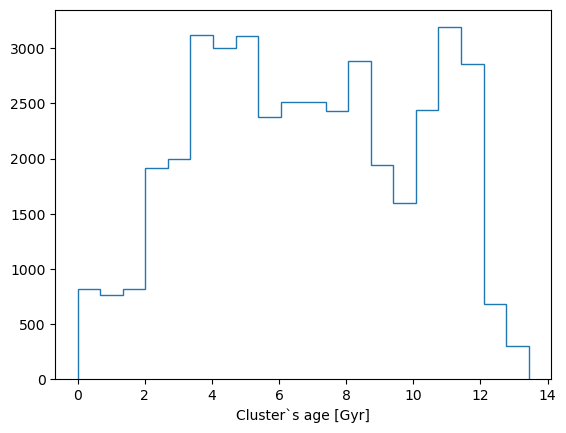

In [35]:
plt.hist(clusters_age, bins=20, histtype='step')
plt.xlabel('Cluster`s age [Gyr]')

Define the age masks

In [36]:
young_mask = (clusters_age<0.5)
old_mask = (clusters_age>4)
veryold_mask = (clusters_age>10)

Compare mass functions

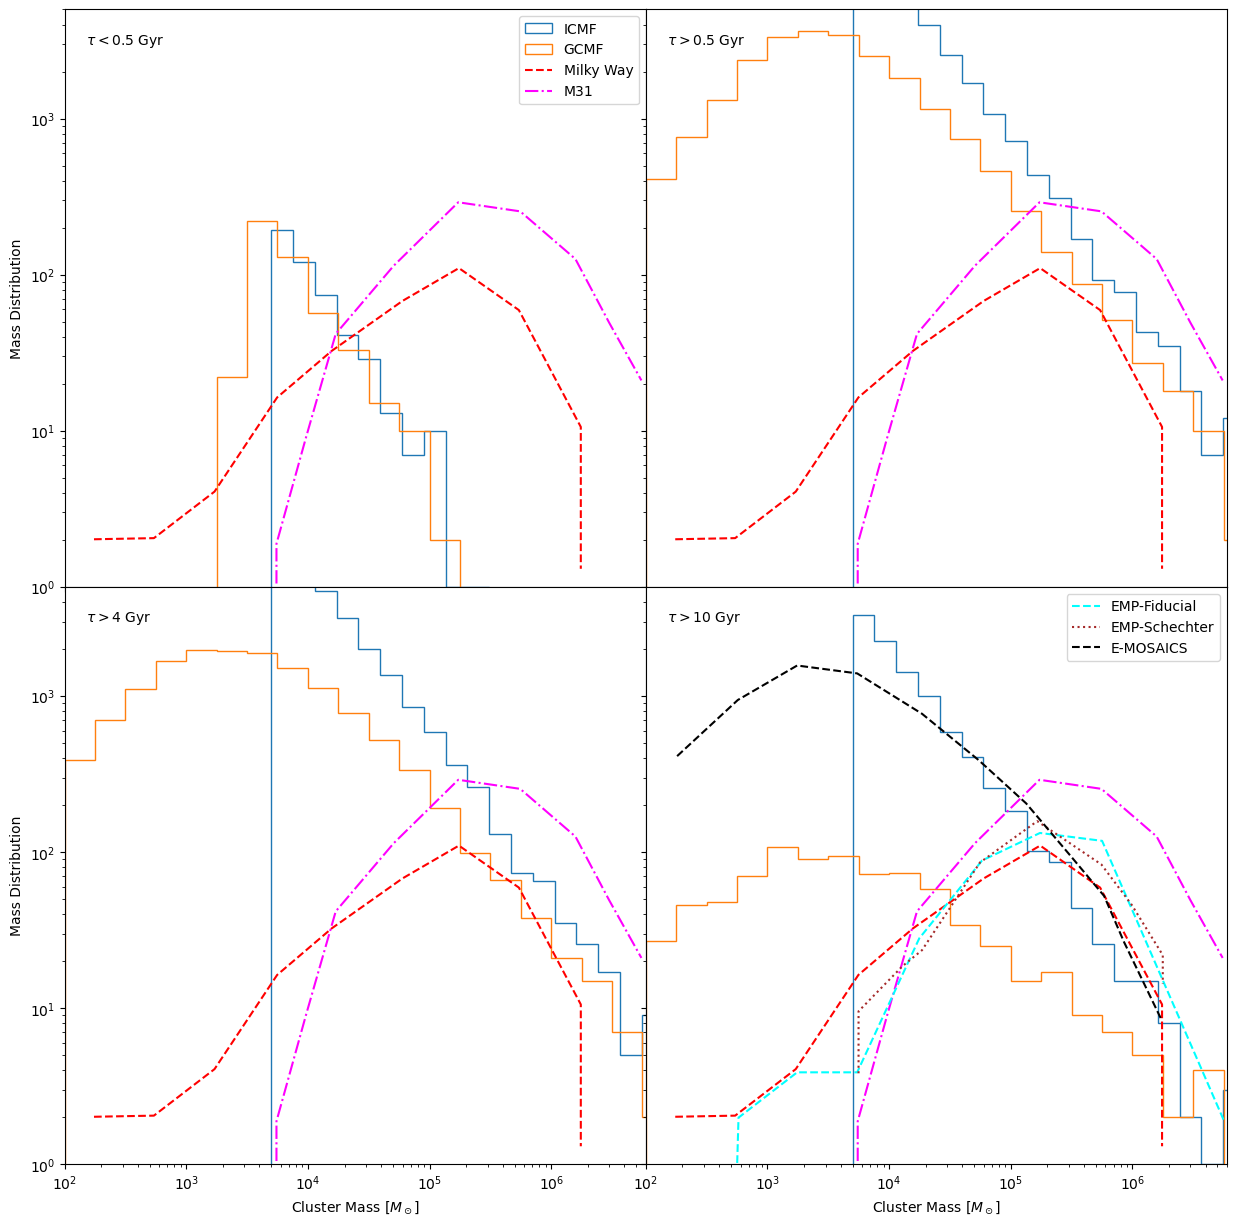

In [37]:
fig, ax = plt.subplots(2,2,sharex='col', sharey='row', figsize=(15, 15))
#Young
# N, _ = np.histogram(np.log10(init_cluster_masses[young_mask]), bins=np.log10(marray_icmf))
# ax[0,0].plot((marray_icmf[:-1] + marray_icmf[1:])/2, N, label='ICMF')
# N, _ = np.histogram(np.log10(cluster_masses[young_mask]), bins=np.log10(marray_gcmf))
# ax[0,0].plot((marray_gcmf[:-1] + marray_gcmf[1:])/2, N, label='GCMF')
ax[0,0].hist(init_cluster_masses[young_mask], bins=marray_icmf, histtype='step', label='ICMF')
ax[0,0].hist(cluster_masses[young_mask], bins=marray_gcmf, histtype='step', label='GCMF')
ax[0,0].plot(MW_gcmf[:,0], MW_gcmf[:,1], linestyle='dashed', color='red', label='Milky Way')
ax[0,0].plot(M31_gcmf[:,0], M31_gcmf[:,1], linestyle='dashdot', color='magenta', label='M31')
ax[0,0].text(1.5e2, 3e3, r'$\tau < 0.5$ Gyr')
ax[0,0].set(ylim=(1e0, 5e3), xscale= 'log', yscale = 'log')
ax[0,0].legend()
ax[0,0].set(ylabel='Mass Distribution')
#Not young
# N, _ = np.histogram(np.log10(init_cluster_masses[np.logical_not(young_mask)]), bins=np.log10(marray_icmf))
# ax[0,1].plot((marray_icmf[:-1] + marray_icmf[1:])/2, N, label='ICMF')
# N, _ = np.histogram(np.log10(cluster_masses[np.logical_not(young_mask)]), bins=np.log10(marray_gcmf))
# ax[0,1].plot((marray_gcmf[:-1] + marray_gcmf[1:])/2, N, label='GCMF')
ax[0,1].hist(init_cluster_masses[np.logical_not(young_mask)], bins=marray_icmf, histtype='step', label='ICMF')
ax[0,1].hist(cluster_masses[np.logical_not(young_mask)], bins=marray_gcmf, histtype='step', label='GCMF')
ax[0,1].plot(MW_gcmf[:,0], MW_gcmf[:,1], linestyle='dashed', color='red', label='Milky Way')
ax[0,1].plot(M31_gcmf[:,0], M31_gcmf[:,1], linestyle='dashdot', color='magenta', label='M31')
ax[0,1].text(1.5e2, 3e3, r'$\tau > 0.5$ Gyr')
ax[0,1].set(xscale= 'log', yscale = 'log')
#Old
# N, _ = np.histogram(np.log10(init_cluster_masses[old_mask]), bins=np.log10(marray_icmf))
# ax[1,0].plot((marray_icmf[:-1] + marray_icmf[1:])/2, N, label='ICMF')
# N, _ = np.histogram(np.log10(cluster_masses[old_mask]), bins=np.log10(marray_gcmf))
# ax[1,0].plot((marray_gcmf[:-1] + marray_gcmf[1:])/2, N, label='GCMF')
ax[1,0].hist(init_cluster_masses[old_mask], bins=marray_icmf, histtype='step', label='ICMF')
ax[1,0].hist(cluster_masses[old_mask], bins=marray_gcmf, histtype='step', label='GCMF')
ax[1,0].plot(MW_gcmf[:,0], MW_gcmf[:,1], linestyle='dashed', color='red', label='Milky Way')
ax[1,0].plot(M31_gcmf[:,0], M31_gcmf[:,1], linestyle='dashdot', color='magenta', label='M31')
ax[1,0].text(1.5e2, 3e3, r'$\tau > 4$ Gyr')
ax[1,0].set(xlim=(min_gcmf, 6e6), ylim=(1e0, 5e3), xscale= 'log', yscale = 'log')
ax[1,0].set(xlabel=r'Cluster Mass [$M_\odot$]', ylabel='Mass Distribution')
#Very old
# N, _ = np.histogram(np.log10(init_cluster_masses[veryold_mask]), bins=np.log10(marray_icmf))
# ax[1,1].plot((marray_icmf[:-1] + marray_icmf[1:])/2, N, label='ICMF')
# N, _ = np.histogram(np.log10(cluster_masses[veryold_mask]), bins=np.log10(marray_gcmf))
# ax[1,1].plot((marray_gcmf[:-1] + marray_gcmf[1:])/2, N, label='GCMF')
ax[1,1].hist(init_cluster_masses[veryold_mask], bins=marray_icmf, histtype='step')
ax[1,1].hist(cluster_masses[veryold_mask], bins=marray_gcmf, histtype='step')
ax[1,1].plot(MW_gcmf[:,0], MW_gcmf[:,1], linestyle='dashed', color='red')
ax[1,1].plot(M31_gcmf[:,0], M31_gcmf[:,1], linestyle='dashdot', color='magenta')
ax[1,1].plot(empfiducial_gcmf[:,0], empfiducial_gcmf[:,1], linestyle='dashed', color='cyan', label='EMP-Fiducial')
ax[1,1].plot(empschecter_gcmf[:,0], empschecter_gcmf[:,1], linestyle='dotted', color='brown', label='EMP-Schechter')
ax[1,1].plot(emosaics_gcmf[:,0], emosaics_gcmf[:,1], linestyle='dashed', color='black', label='E-MOSAICS')
ax[1,1].text(1.5e2, 3e3, r'$\tau > 10$ Gyr')
ax[1,1].set(xlim=(min_gcmf, 6e6), xscale= 'log', yscale = 'log')
ax[1,1].set(xlabel=r'Cluster Mass [$M_\odot$]')
ax[1,1].legend()

fig.subplots_adjust(hspace=0, wspace=0)
# plt.savefig('mass_dist_fullevo_age_new.pdf')

This is at first dependent on the truncation mass of the ICMF, so let's take a look at its distribution

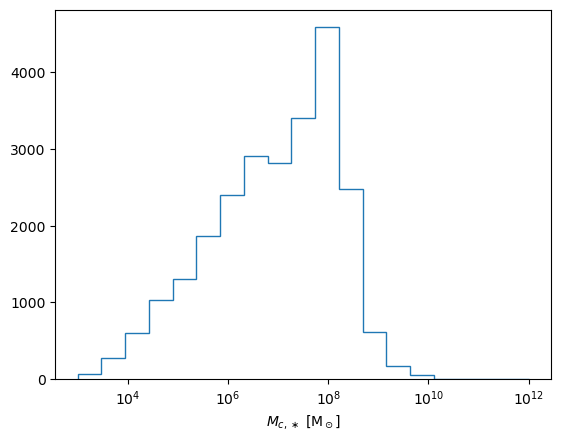

In [38]:
bins = np.logspace(3,12,20)
plt.hist(truncation_mass, bins=bins, histtype='step')
plt.xlabel(r'$M_{c,\ast}$ [M$_\odot$]')
plt.xscale('log')

## Lifetime and mass loss from dynamic evolution

First define a function to perform a scatter plot colored by density

In [39]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, **kwargs )

    return ax, h

Now, plot the lifetime of clusters

In [47]:
fraction = []
for i in range(24):
  mask = (init_cluster_masses[veryold_mask] > marray_icmf[i]) & (init_cluster_masses[veryold_mask] < marray_icmf[i+1])
  mask_disrupted = (clusters_disruptiontime[veryold_mask][mask]>0)
  fraction.append(mask_disrupted.sum()/mask.sum())

fraction = np.array(fraction)
fraction = np.nan_to_num(fraction, nan=0.)

/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/array.py:353: RuntimeWarning: invalid value encountered in divide
  return np.ndarray.__truediv__(self, rhs)


In [50]:
massfraction = []
for i in range(24):
  mask = (init_cluster_masses[veryold_mask] > marray_icmf[i]) & (init_cluster_masses[veryold_mask] < marray_icmf[i+1])
  massfraction.append(cluster_masses[veryold_mask][mask].sum()/init_cluster_masses[veryold_mask][mask].sum())

massfraction = np.array(massfraction)
massfraction = np.nan_to_num(massfraction, nan=0.)

/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/array.py:353: RuntimeWarning: invalid value encountered in divide
  return np.ndarray.__truediv__(self, rhs)


Text(0, 0.5, 'Number')

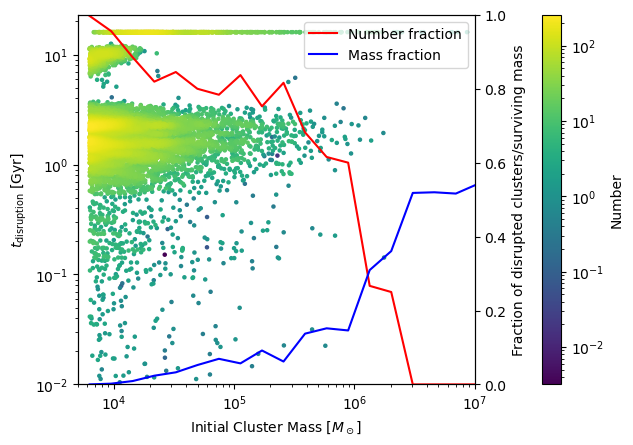

In [52]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twinx()
ax1, cb = density_scatter(init_cluster_masses[veryold_mask], lifetime_gyr[veryold_mask], ax=ax1, bins=[marray_icmf, np.logspace(-2,1.5,100)], edgecolors='face', s=5, norm='log')
ax1.set(xscale='log', yscale='log', xlim=(5e3, 1e7), ylim=(1e-2, 2.3e1))
ax1.set(xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$t_{\rm{disruption}}$ [$\rm{Gyr}$]')
ax2.plot((marray_icmf[:-1] + marray_icmf[1:])/2, fraction, color='r', label='Number fraction')
ax2.plot((marray_icmf[:-1] + marray_icmf[1:])/2, massfraction, color='b', label='Mass fraction')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Fraction of disrupted clusters/surviving mass')
ax2.legend()

cbar = fig.colorbar(cb, ax=ax1)
# Move the colorbar to a new position
new_position = fig.add_axes([0.85, 0.11, 0.03, 0.77])
cbar.ax.remove()
cbar = fig.colorbar(cb, cax=new_position)
cbar.ax.set_ylabel('Number')
# plt.savefig('disrupted_new.pdf')

And the mass lost by each dynamic mechanism

In [42]:
mevminit = masslostrelax/init_cluster_masses
mshminit = masslostshock/init_cluster_masses
mshminit[(mshminit>1)] = 1

Text(0, 0.5, 'Number')

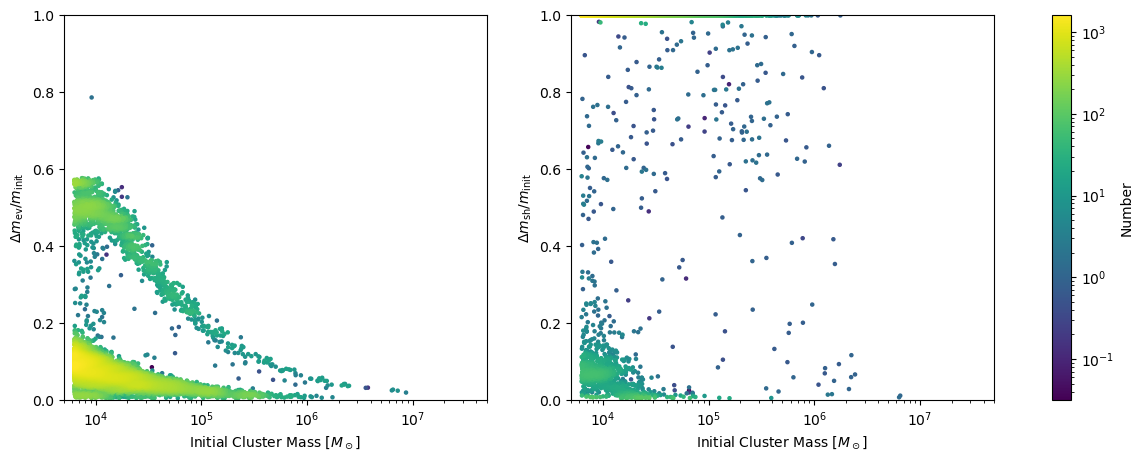

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0], cb = density_scatter(init_cluster_masses[veryold_mask], mevminit[veryold_mask], ax=ax[0],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5, norm='log')
ax[1], cb = density_scatter(init_cluster_masses[veryold_mask], mshminit[veryold_mask], ax=ax[1],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5, norm='log')
ax[0].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{ev}}/m_{\rm{init}}$')
ax[1].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{sh}}/m_{\rm{init}}$')
cbar = fig.colorbar(cb, ax=ax)
cbar.ax.set_ylabel('Number')
# plt.savefig('lostmass_new.pdf')

Are we comparing apples to apples? Not sure, I guess that Marta's plots are with respect to their fiducial model that implementes a minimimum truncation mass in the ICMF too. This changes the ammount of low mass clusters.

In [73]:
G = 6.674e-8 # In cgs cm3 s-2 g-1
kpc = 3.09e21 # in cm
msun = 1.989e33 # in g
gyr = 3.15576e16 # in s
T_str = 4e2 # Gyr-2
rh = 4 # pc
m1 = 0.42*1.5e4 # Msun
xi_0 = 0.0142
z = 1.61
x = 0.75
rhrt1 = 0.145
zeta = 0.1

In [74]:
rt = (G * marray_icmf * msun / (T_str / gyr**2))**(1./3.) / kpc

In [67]:
Pfact = (rh / rt / rhrt1)**z * (marray_icmf * np.log(0.11 * m1) / (m1 * np.log(0.11 * marray_icmf)))**(1. - x)

In [81]:
xi = xi_0 * (1. - Pfact) + 0.6 * zeta * Pfact

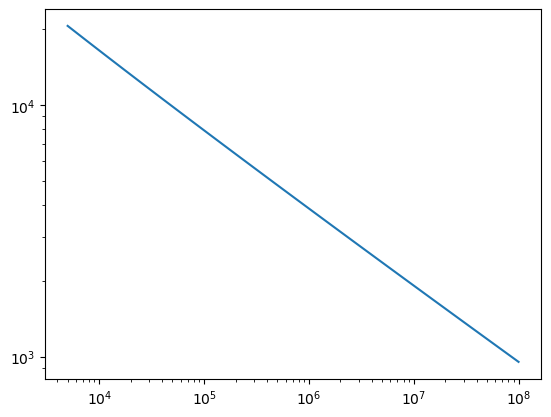

In [69]:
plt.loglog(marray_icmf, xi)